In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pyplot as plt
# DeepMoD stuff
from deepymod import DeepMoD
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from deepymod.data import Dataset
from deepymod.data.burgers import BurgersDelta

#if torch.cuda.is_available():
#    device = 'cuda'
#else:
device = 'cpu'

# Settings for reproducibility
np.random.seed(44)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Making dataset

noise = 0.01
A = 1
v = 0.25

In [2]:
runs = 1
dataset = Dataset(BurgersDelta, A=A, v=v)

x = np.linspace(-3.9, 4.2, 120) 
t = np.linspace(0.1, 1.1, 100) 
t_grid, x_grid = np.meshgrid(t, x, indexing='ij')
X, y = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=noise, random=False, normalize=False)
X.shape
xt = X.reshape(x_grid.shape[0],x_grid.shape[1],2)
yt = y.reshape(x_grid.shape[0],x_grid.shape[1])

In [3]:
xt.shape

torch.Size([100, 120, 2])

In [4]:
delta_x = 6
shift = np.mod(np.arange(0,xt.shape[0]),delta_x)
shifted_X, shifted_Y = [], []

In [5]:
cut_off = np.int((xt.shape[1]/delta_x)-1)
ytrain = np.empty([yt.shape[0],cut_off])
xtrain = np.empty([xt.shape[0],cut_off,xt.shape[2]])

In [6]:
for i in np.arange(yt.shape[0]):
    ytrain[i,:] = yt[i,shift[i]:-1:delta_x][:cut_off]
    xtrain[i,:,0] = xt[i,shift[i]:-1:delta_x,0][:cut_off]
    xtrain[i,:,1] = xt[i,shift[i]:-1:delta_x,1][:cut_off]

In [7]:
delta_x = 10
shift = np.mod(np.arange(0,xt.shape[0]),delta_x)
shifted_X, shifted_Y = [], []

cut_off = np.int((xt.shape[1]/delta_x)-1)
ytrain = np.empty([yt.shape[0],cut_off])
xtrain = np.empty([xt.shape[0],cut_off,xt.shape[2]])

for i in np.arange(yt.shape[0]):
    ytrain[i,:] = yt[i,shift[i]:-1:delta_x][:cut_off]
    xtrain[i,:,0] = xt[i,shift[i]:-1:delta_x,0][:cut_off]
    xtrain[i,:,1] = xt[i,shift[i]:-1:delta_x,1][:cut_off]

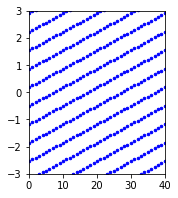

In [15]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.plot(xtrain[:,:,1],'bo', markersize=2.5)
ax.set_aspect(aspect=8)
ax.set_ylim([-3.0,3.0])
ax.set_xlim([0,40.0])
plt.savefig('shifted.pdf')
plt.show()

In [86]:
(np.random.rand(1,n_x)-0.5)*10

array([[-0.43503583, -0.07276508, -3.91026496, -3.46265539,  4.84284033,
        -2.28439846,  3.97151887, -3.35765354, -3.67641705, -1.82646597]])

In [17]:
number_of_samples= 10

In [18]:
ytrain = np.empty([yt.shape[0],number_of_samples])
xtrain = np.empty([xt.shape[0],number_of_samples,xt.shape[2]])
for i in np.arange(yt.shape[0]):
    idx = np.random.permutation(yt.shape[1])
    ytrain[i,:] = yt[i,idx][:number_of_samples]
    xtrain[i,:,0] = xt[i,idx,0][:number_of_samples]
    xtrain[i,:,1] = xt[i,idx,1][:number_of_samples]



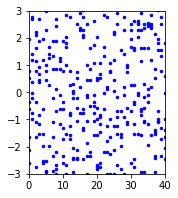

In [19]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.plot(xtrain[:,:,1],'bo', markersize=2.5)
ax.set_aspect(aspect=8)
ax.set_ylim([-3.0,3.0])
ax.set_xlim([0,40.0])
plt.savefig('random.pdf')
plt.show()

In [20]:
x = np.linspace(-4, 4, 12) 
t = np.linspace(0.1, 1.1, 100) 
t_grid, x_grid = np.meshgrid(t, x, indexing='ij')

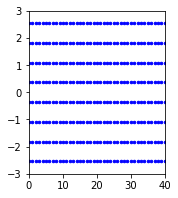

In [21]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.plot(x_grid,'bo', markersize=2.5)
ax.set_aspect(aspect=8)
ax.set_ylim([-3.0,3.0])
ax.set_xlim([0,40.0])
plt.savefig('grid.pdf')
plt.show()

In [4]:
for nx in [16,14]:   
    delta_x = nx
    shift = np.mod(np.arange(0,xt.shape[0]),delta_x)
    shifted_X, shifted_Y = [], []

    cut_off = np.int((xt.shape[1]/delta_x)-1)
    ytrain = np.empty([yt.shape[0],cut_off])
    xtrain = np.empty([xt.shape[0],cut_off,xt.shape[2]])

    for i in np.arange(yt.shape[0]):
        ytrain[i,:] = yt[i,shift[i]:-1:delta_x][:cut_off]
        xtrain[i,:,0] = xt[i,shift[i]:-1:delta_x,0][:cut_off]
        xtrain[i,:,1] = xt[i,shift[i]:-1:delta_x,1][:cut_off]

    xtrain = np.transpose(xtrain,axes=(1,0,2))
    ytrain = ytrain.T
    X = torch.tensor(xtrain.reshape(-1,2), dtype=torch.float32, requires_grad=True)
    y = torch.tensor(ytrain.reshape(-1,1), dtype=torch.float32)

    idx = np.random.permutation(y.shape[0])
    y = y[idx]
    X[:,0] = X[idx,0]
    X[:,1] = X[idx,1]

    X, y = X.to(device), y.to(device)
    network = NN(2, [30, 30, 30, 30], 1)
    library = Library1D(poly_order=2, diff_order=3) # Library function
    estimator = Threshold(0.2) # Sparse estimator 
    constraint = LeastSquares() # How to constrain
    model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

    sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=500, delta=1e-7) # in terms of write iterations
    optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) # Defining optimizer

    train(model, X, y, optimizer, sparsity_scheduler, log_dir='runs/shifted_grid_'+str(cut_off), split=0.8, write_iterations=25, max_iterations=100000, delta=1e-4, patience=500) 
    print(model.constraint_coeffs(sparse=True, scaled=True))

 27025  MSE: 9.29e-06  Reg: 3.53e-06  L1: 1.87e+00 Algorithm converged. Writing model to disk.
[tensor([[-0.0016],
        [-0.0520],
        [ 0.8319],
        [ 0.0850],
        [ 0.0263],
        [-0.4082],
        [-0.2292],
        [ 0.0216],
        [-0.0665],
        [-0.0149],
        [ 0.1240],
        [-0.0127]], grad_fn=<MulBackward0>)]
 59700  MSE: 7.90e-06  Reg: 3.98e-06  L1: 1.36e+00 Algorithm converged. Writing model to disk.
[tensor([[ 0.0000],
        [ 0.0000],
        [ 0.7504],
        [ 0.0000],
        [ 0.0000],
        [-0.6115],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]], grad_fn=<MulBackward0>)]


In [4]:

for n_x in np.array([2]):
    number_of_samples = n_x
    ytrain = np.empty([yt.shape[0],number_of_samples])
    xtrain = np.empty([xt.shape[0],number_of_samples,xt.shape[2]])
    for i in np.arange(yt.shape[0]):
        idx = np.random.permutation(yt.shape[1])
        ytrain[i,:] = yt[i,idx][:number_of_samples]
        xtrain[i,:,0] = xt[i,idx,0][:number_of_samples]
        xtrain[i,:,1] = xt[i,idx,1][:number_of_samples]
    xtrain_b = np.transpose(xtrain,axes=(1,0,2))
    ytrain_b = ytrain.T
    X = torch.tensor(xtrain_b.reshape(-1,2), dtype=torch.float32, requires_grad=True)
    y = torch.tensor(ytrain_b.reshape(-1,1), dtype=torch.float32)
    print(y.shape)
    X, y = X.to(device), y.to(device)
    network = NN(2, [30, 30, 30, 30], 1)
    library = Library1D(poly_order=2, diff_order=3) # Library function
    estimator = Threshold(0.2) # Sparse estimator 
    constraint = LeastSquares() # How to constrain
    model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

    sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=500, delta=1e-7) # in terms of write iterations
    optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) # Defining optimizer

  #  train(model, X, y, optimizer, sparsity_scheduler, log_dir='runs/random_grid'+str(n_x), split=0.8, write_iterations=25, max_iterations=100000, delta=1e-4, patience=500) 
    print(model.constraint_coeffs(sparse=True, scaled=True))

torch.Size([200, 1])
 14550  MSE: 8.34e-04  Reg: 7.65e-05  L1: 1.94e+00 Algorithm converged. Writing model to disk.
[tensor([[ 0.0000],
        [-1.0442],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.8944],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]], grad_fn=<MulBackward0>)]


In [ ]:
for n_x in np.array([4,6,8,10,12,14,16]):
    for run in np.arange(runs):
        
        number_of_samples = n_x * 100
        idx = np.random.permutation(y.shape[0])
        X = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
        y = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)
        X, y = X.to(device), y.to(device)
        network = NN(2, [30, 30, 30, 30], 1)
        library = Library1D(poly_order=2, diff_order=3) # Library function
        estimator = Threshold(0.2) # Sparse estimator 
        constraint = LeastSquares() # How to constrain
        model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

        sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=500, delta=1e-7) # in terms of write iterations
        optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) # Defining optimizer

        train(model, X, y, optimizer, sparsity_scheduler, log_dir='runs/rand'+str(n_x), split=0.8, write_iterations=25, max_iterations=100000, delta=1e-4, patience=500) 
        print(model.constraint_coeffs(sparse=True, scaled=True))

 28500  MSE: 8.57e-06  Reg: 4.27e-06  L1: 1.41e+00 Algorithm converged. Writing model to disk.
[tensor([[ 0.0000],
        [ 0.0000],
        [ 0.6382],
        [ 0.0000],
        [ 0.0000],
        [-0.7670],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]], device='cuda:0', grad_fn=<MulBackward0>)]
 99975  MSE: 6.56e-06  Reg: 9.61e-07  L1: 3.85e+00 Algorithm converged. Writing model to disk.
[tensor([[ 7.9732e-04],
        [-3.5464e-02],
        [ 6.7906e-01],
        [ 6.0199e-02],
        [ 2.7272e-01],
        [-8.8315e-01],
        [-3.8879e-01],
        [-2.4706e-01],
        [-4.5990e-01],
        [ 2.9216e-01],
        [ 2.1149e-01],
        [ 3.2241e-01]], device='cuda:0', grad_fn=<MulBackward0>)]
 36300  MSE: 1.05e-05  Reg: 4.87e-06  L1: 1.46e+00 